In [1]:
# Import the needed libraries
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

from scipy.stats import halfnorm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import the data

In [2]:
# Import two datasets containing the required data
df = pd.read_csv("./Data/titles.csv")
df2 = pd.read_csv("./Data/credits.csv")

In [3]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [4]:
df2.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [5]:
# Merge the two datasets
netflix = pd.merge(df, df2[df2["role"] == "DIRECTOR"], on=["id"])
netflix.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,3308,Martin Scorsese,NaN,DIRECTOR
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,17727,John Boorman,NaN,DIRECTOR
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11475,Terry Jones,NaN,DIRECTOR
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11473,Terry Gilliam,NaN,DIRECTOR
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,1063,Robert Aldrich,NaN,DIRECTOR


In [6]:
# Drop unwanted features and rename 'name' into 'director'
netflix.drop(["person_id", 'role', 'character'], inplace=True, axis=1)
netflix.rename(columns={'name': 'director'}, inplace=True)

In [7]:
# Check for null values  in the data
netflix.info()

# Just 'seasons' contain a considerable amount of null values, but it is fine as films do not have information on the season, 
# and tv shows of 1 season also do not have info on the seasons number.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4550 non-null   object 
 1   title                 4549 non-null   object 
 2   type                  4550 non-null   object 
 3   description           4546 non-null   object 
 4   release_year          4550 non-null   int64  
 5   age_certification     2006 non-null   object 
 6   runtime               4550 non-null   int64  
 7   genres                4550 non-null   object 
 8   production_countries  4550 non-null   object 
 9   seasons               679 non-null    float64
 10  imdb_id               4222 non-null   object 
 11  imdb_score            4167 non-null   float64
 12  imdb_votes            4148 non-null   float64
 13  tmdb_popularity       4549 non-null   float64
 14  tmdb_score            4419 non-null   float64
 15  director             

In [8]:
# drop unused features
netflix.drop(['imdb_id', 'id', 'description'], axis=1, inplace=True)

print(netflix.shape)
netflix.head()

(4550, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [9]:
# Drop rows with no title
netflix.dropna(subset=['title', 'director', 'imdb_score', 'tmdb_score'], inplace=True)

print(netflix.shape)
netflix.head()

(4079, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [10]:
# netflix['is_drama'] = netflix['genres'].apply(lambda x: 'drama' in x)
# netflix['is_action'] = netflix['genres'].apply(lambda x: 'action' in x)
# netflix['is_comedy'] = netflix['genres'].apply(lambda x: 'comedy' in x)

# netflix.head()

In [11]:
# drama = netflix[netflix['is_drama'] == True]
# comedy = netflix[netflix['is_comedy'] == True]
# print(len(drama), len(comedy))

In [12]:
# netflix["director"] = netflix["director"].astype("category")
# directors = list(netflix["director"].cat.categories) 

# Hypothesis testing

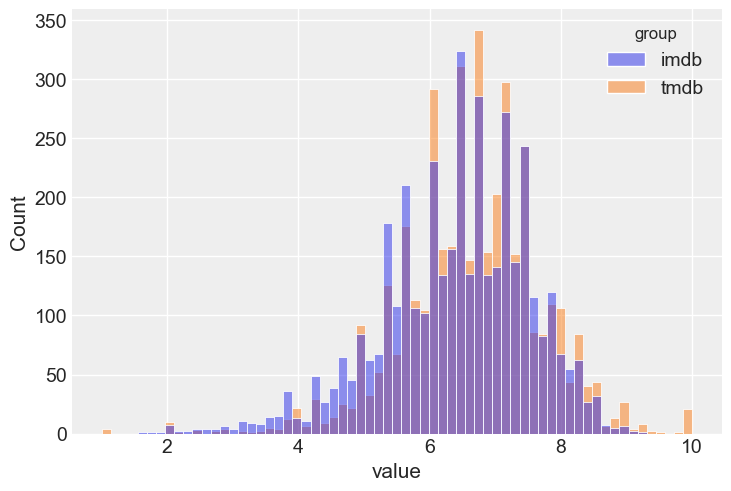

In [13]:
# Check the distribution of the two scores, from imdb and from tmbdb
y  = pd.DataFrame(dict(value=np.r_[netflix['imdb_score'], netflix['tmdb_score']], 
                       group=np.r_[['imdb']*len(netflix['imdb_score']), ['tmdb']*len(netflix['tmdb_score'])]))

sns.histplot(data=y, x="value", hue="group");

### Research questions

Possible question 1: is the hypothesis of equal means of the two populations(imdb scores and tmdb scores) plausible?

Possible question 2: which is the probability of the two database to have the same score?

* We will fit a normal-normal model on each group.


* Then we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}

In [14]:
# Compute the mean score and standard deviation for imdb and tmdb
netflix_describe = netflix.describe()

# Mean scores
imdb_mean = netflix_describe['imdb_score'].loc['mean']
tmdb_mean = netflix_describe['tmdb_score'].loc['mean']
print("imdb mean score:", imdb_mean)
print("tmdb mean score:", tmdb_mean)
scores_mean = (imdb_mean + tmdb_mean)/2
print('mean score:', scores_mean)

# Standard deviations
imdb_std = netflix_describe['imdb_score'].loc['std']
tmdb_std = netflix_describe['tmdb_score'].loc['std']
print("\nimdb std:", imdb_std)
print("tmdb std:", tmdb_std)
std_mean = (imdb_std + tmdb_std)/2
print('mean std:', std_mean)

imdb mean score: 6.389899485167937
tmdb mean score: 6.622134346653581
mean score: 6.5060169159107595

imdb std: 1.1332380635930401
tmdb std: 1.0673718042503184
mean std: 1.1003049339216793


### Background information to set the prior

* The mean of the scores is about 6.5.
* The score of movies and tv shows follow a normal distribution, its mean can be assumed to be in (4.5, 8.5).
* Extreme values for the score are 1 (very poorly-made film) and 10 (masterpiece film). A plausible value for the standard deviation in the population is thus (6.5-1)/2 = 2.75.

### Prior for $\mu_{\text{imdb}}$ and $\mu_{\text{tmdb}}$

* The mean score of the population lies in (4.5, 8.5);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{imdb}}   \sim  N (6.5, 1.375)
$$
$$
\mu_{\text{tmdb}}   \sim  N (6.5, 1.375)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

Ideally we tune the half-normal prior for sigma, adjusting the scale to have the median close to 2.75. In our case we don't want values over 10 since it is the maximun score so we tuned the scale to have a maximun value of about 10.

In [15]:
# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=2.7, size=10000)).describe()

,0
count,10000.000000
mean,2.168095
std,1.633094
min,0.000448
25%,0.882789
50%,1.836124
75%,3.106749
max,10.330372


### Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$\vec{y}_{imdb} \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}})$$

$$\vec{y}_{tmdb} \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})$$

where we use the vector notation to make it clear that these are array of measures.

###  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{imdb}} & \sim N(6.5,1.133) \\
\sigma_{\text{imdb}} & \sim \text{half-normal} (2.75) \\
\vec{y}_{\text{imdb}}  & \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}}) \\
\\
\mu_{\text{tmdb}} & \sim N(6.5,1.067) \\
\sigma_{\text{tmdb}} & \sim \text{half-normal} (2.75) \\
\vec{y}_{\text{tmdb}}  & \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})\\
\end{align*}


### Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can define it as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have the posterior samples of ($\mu_1 - \mu_2$) in the trace.

In [16]:
with pm.Model() as score_model_1:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu=6.5, sd=1.5)
    mu_tmdb = pm.Normal('mu_tmdb', mu=6.5, sd=1.5)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.75)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.75)
    
    #likelihood of group 1
    y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed= netflix['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed= netflix['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [17]:
with score_model_1:
    score_model_1_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


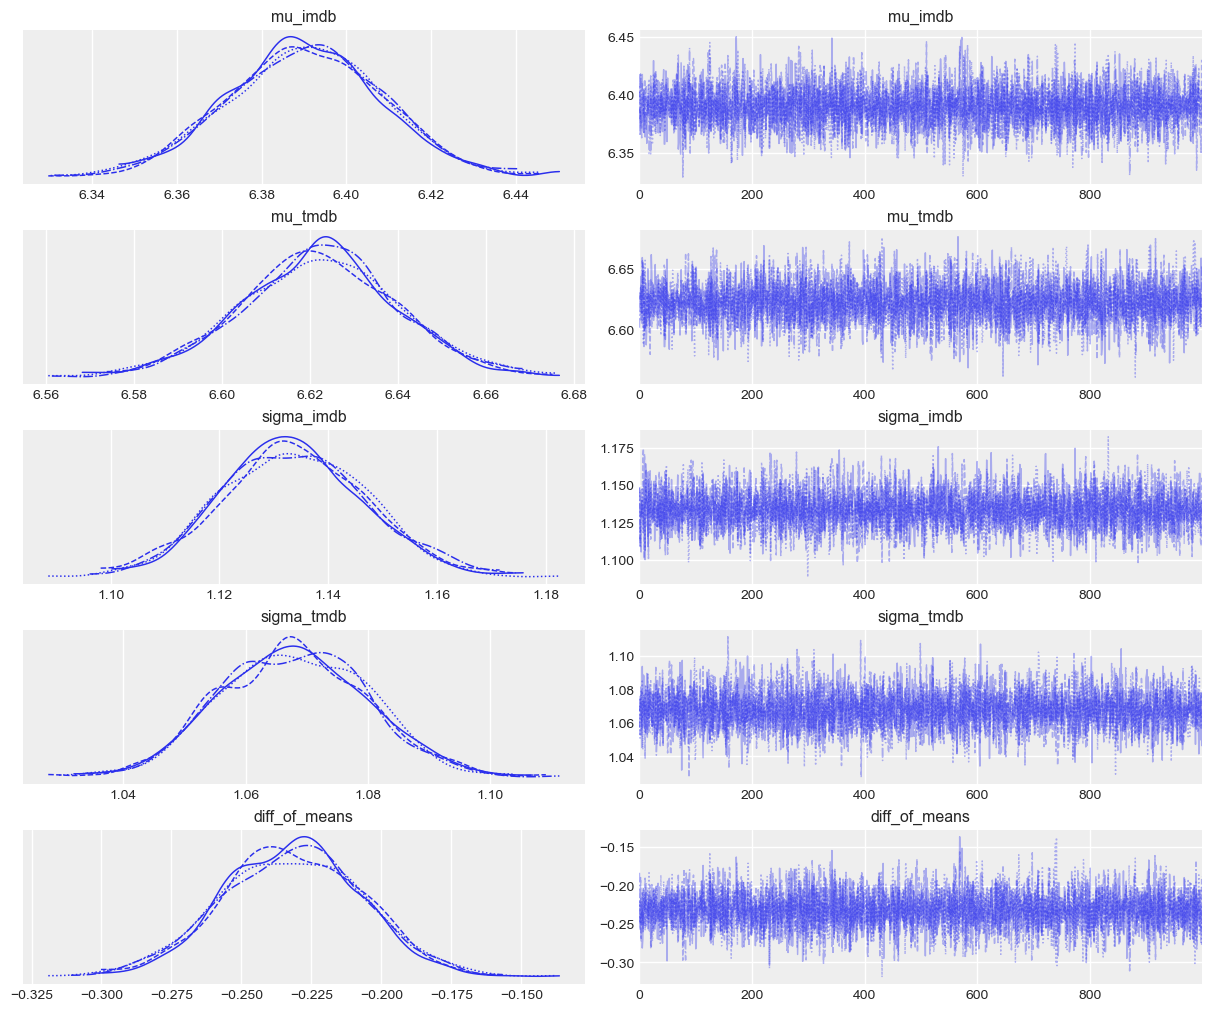

In [18]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(score_model_1_trace);

In [19]:
with pm.Model() as score_model_2:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu=imdb_mean, sd=imdb_std)
    mu_tmdb = pm.Normal('mu_tmdb', mu=tmdb_mean, sd=tmdb_std)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.75)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.75)
    
    #likelihood of group 1
    y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed= netflix['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed= netflix['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [20]:
with score_model_2:
    score_model_2_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


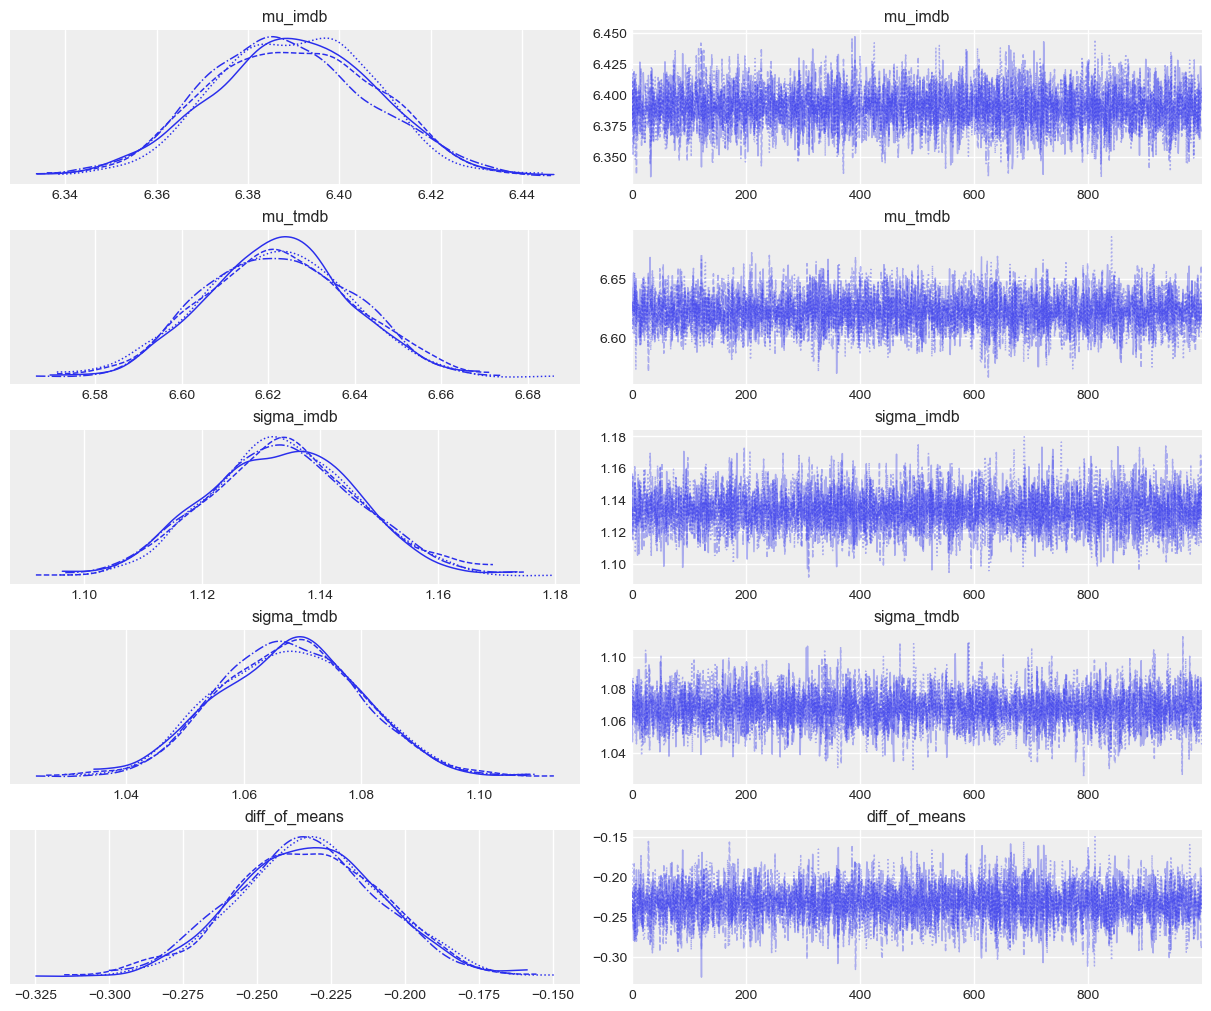

In [21]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(score_model_2_trace);

To test the prior sensitivity...

In [22]:
# Prior sensitivity

Possible question 1: is the hypothesis of equal means of the two populations plausible?
In traditional hypothesis testing, this corresponds to test the  hypothesis diff mu = 0.
Formally the 0 is a plausible value (although at the very limit of the 95% HDI) 

In [23]:
az.summary(score_model_1_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,6.390,0.018,6.354,6.424,0.0,0.0,6329.0,3082.0,1.0
mu_tmdb,6.622,0.018,6.586,6.656,0.0,0.0,6740.0,3297.0,1.0
sigma_imdb,1.134,0.013,1.109,1.160,0.0,0.0,7211.0,2917.0,1.0
sigma_tmdb,1.068,0.012,1.046,1.091,0.0,0.0,6853.0,3108.0,1.0
diff_of_means,-0.232,0.025,-0.282,-0.184,0.0,0.0,6975.0,3107.0,1.0


In [24]:
az.summary(score_model_2_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,6.390,0.018,6.356,6.424,0.0,0.0,6528.0,3214.0,1.0
mu_tmdb,6.622,0.017,6.591,6.655,0.0,0.0,6250.0,3383.0,1.0
sigma_imdb,1.134,0.013,1.110,1.160,0.0,0.0,7161.0,3260.0,1.0
sigma_tmdb,1.068,0.012,1.044,1.090,0.0,0.0,5714.0,3320.0,1.0
diff_of_means,-0.233,0.025,-0.282,-0.187,0.0,0.0,6182.0,2923.0,1.0


Here our difference of means is 0.232, so we can say that the two means are practically equal.

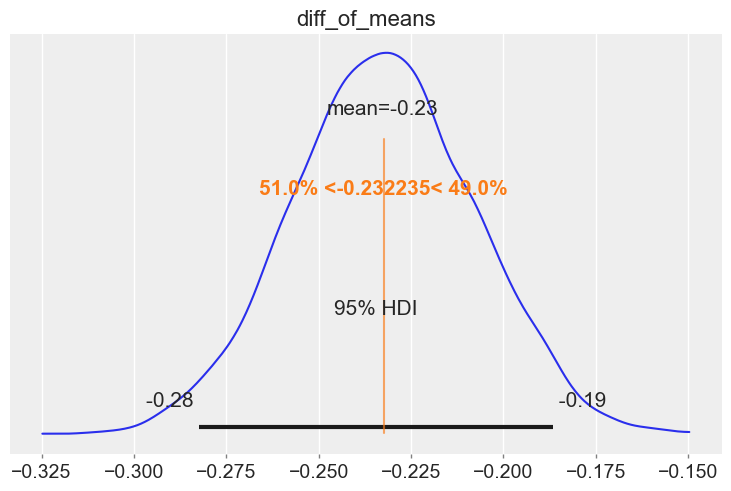

In [25]:
# Possible question 2: which is the posterior probability of an higher score in imdb scoreboard?
r_val = imdb_mean - tmdb_mean
#There is a probability >95% of tmdb giving an higher score than imdb; thus we accept the hypothesis oftmdb giving higher scores.
az.plot_posterior(score_model_2_trace,  var_names="diff_of_means", ref_val=r_val, hdi_prob=0.95);

We used as reference value the actual difference between the two populations means and we see it fall almost exactly in the middle of the posterior distribution. We can't say that imdb has generally higher scores than tmdb or viceversa.

# Organize data

In [26]:
# n = 10
# c = netflix.groupby(['director']).count()
# c = c.sort_values('title', ascending=False)
# d_mask = c.iloc[:n].reset_index()
# directors = netflix[netflix["director"].isin(d_mask["director"])].reset_index(drop=True)
# directors

In [27]:
netflix["before_2010"] = netflix["release_year"] <= 2010

In [28]:
netflix["before_2010"].value_counts()

False    3592
True      487
Name: before_2010, dtype: int64

In [29]:
df = netflix[netflix["type"] != 'SHOW']

In [30]:
# df = pd.concat([df1, df2], ignore_index=True)
# df["before_2010"].value_counts()

In [31]:
# c = df.groupby(['director']).count().sort_values('title', ascending=False)
# c.head(50)

In [32]:
#list of directors with films in netflix catalogue
directors_names = df.director.unique()
n_directors = directors_names.shape[0] 

#numerical id of the director of each film
direc = df["director"].astype("category")
directors_code = direc.cat.codes
#code and name of each director
directors_lookup = dict(zip(directors_names, np.arange(n_directors)))

#explanatory variable: whether the film came out before 2010.
before_2010 = df.before_2010.values

#y 
score = df.imdb_score.values

In [33]:
# df[df["director"] == 'Martin Scorsese']

# Pooled regression

A regression model which ignores the director:

$$Y \sim N( \alpha + \beta X, \sigma)$$


* $Y$: imdb score (919 measures)

* $X$: film (1 or 0)

* $\alpha$ : intercept.  (on  centered data, it represents the mean log-radon in Minnesota). 


* We use the centered covariate  $X_c = X - \bar{x}$


* We have no prior knowledge and thus we use fall back to  weakly informative, data-dependent, priors:

\begin{align}
Y  &\sim N( \alpha_c + \beta X_c,  \sigma) && \text{likelihood}\\
\alpha &\sim N(\bar{y},2 s_y) && \text{prior on the intercept} \\
\beta  & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the dev std } \\
\end{align}

In [34]:
#implementation of the pooled model

#centering is needed to have effective sampling
before_2010_c  = (before_2010 - before_2010.mean())
mu_y = score.mean()
s_y = score.std()
s_x = before_2010_c.std()

with pm.Model() as pooled_model:

    alpha = pm.Normal('alpha', mu= mu_y,  sigma= 2 * s_y)
    beta = pm.Normal('beta', mu=0,  sigma= 2.5 * s_y/s_x)
    sigma = pm.HalfNormal('sigma', 1.5 * s_y)
    y = pm.Normal('y', alpha + beta * before_2010_c, sigma, observed=score)
    

In [35]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


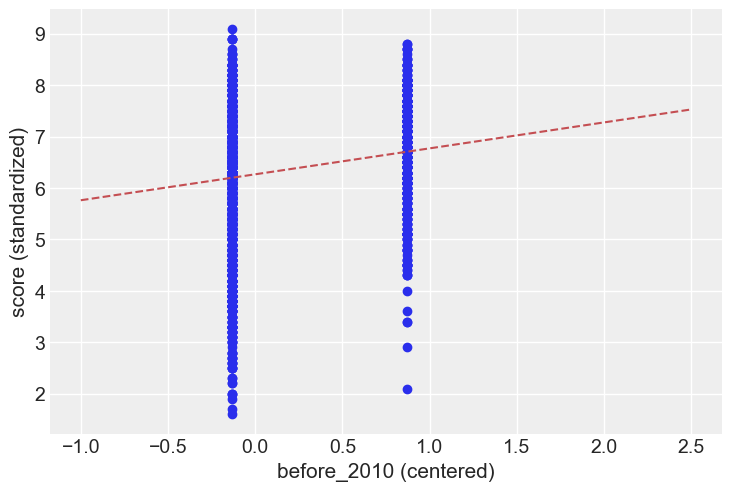

In [36]:
# posterior mean of the parameters
post_pooled = az.extract_dataset(pooled_trace)
a_pooled      =  post_pooled.alpha.values.mean()
b_pooled      = post_pooled.beta.values.mean()

plt.scatter(before_2010_c, score)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('before_2010 (centered)')
plt.ylabel('score (standardized)');

 # Unpooled regression

In [37]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    alpha = pm.Normal('alpha', mu=mu_y, sigma=2 * s_y, shape=n_directors)

    # the slope is the same for all counties
    beta           = pm.Normal('beta', mu=0, sigma=2 * s_y/s_x)
    sigma_y   = pm.HalfNormal('sigma_y', 1.5 * s_y)
    
    #county is a vector containing the county index  for each measure.
    mu = alpha[directors_code] + beta * before_2010_c
    
    y = pm.Normal('y', mu, sigma=sigma_y, observed=score)
    

In [38]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.7034260164992102, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7184544824302525, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7135179840253638, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


# Hierarchical regression

\begin{align}
Y &\sim N( \alpha_{j[i]} + \beta X_c,  \sigma) && \text{likelihood} \\
\beta & \sim N (0,2  \frac{s_y}{s_x} )  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 85&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\end{align}

* Broad priors  on the parameters of the population of intercepts


* This is  a **varying-intercept** model, since the intercept is different for each county, while the slope is unique for  all counties.


In [39]:
with pm.Model() as hier_model:
    
    # Parameters of the population of intercepts, to which we assign broad priors.
    mu_a     = pm.Normal('mu_a', mu=mu_y, sigma=1 * s_y)
    sigma_a = pm.HalfNormal('sigma_a', 1 * s_y)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_directors)
    
    # Common slope
    beta = pm.Normal('beta', mu=0, sigma= 2.5 *  s_y / s_x)
    
    # Prior on sigma
    sigma_y = pm.HalfCauchy('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[directors_code] + beta * before_2010_c, sigma=sigma_y, observed=score)    

In [40]:
with hier_model:
    hier_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [41]:
az.summary(hier_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,6.244,0.020,6.204,6.281,0.000,0.000,3013.0,2477.0,1.00
alpha[0],6.134,0.453,5.268,7.006,0.006,0.004,5538.0,2127.0,1.00
alpha[1],5.262,0.554,4.261,6.322,0.008,0.006,5065.0,1824.0,1.00
alpha[2],6.547,0.462,5.650,7.413,0.006,0.004,6382.0,1857.0,1.00
alpha[3],5.774,0.542,4.745,6.791,0.007,0.005,5908.0,1823.0,1.01
...,...,...,...,...,...,...,...,...,...
alpha[2639],6.253,0.552,5.268,7.289,0.007,0.005,5911.0,1981.0,1.00
alpha[2640],5.575,0.442,4.763,6.420,0.006,0.004,5002.0,2222.0,1.00
beta,0.480,0.056,0.381,0.589,0.001,0.001,3162.0,2389.0,1.00
sigma_a,0.756,0.025,0.711,0.803,0.001,0.001,790.0,1209.0,1.00


In [42]:
# df.director.unique()

In [43]:
# bho = df[df["before_2010"] == True]
# bho.director.unique()

In [44]:
# sample_directors = ('James Cameron', 'Sylvester Stallone', 'Paul Thomas Anderson',
#        'Christopher Nolan')

sample_directors = ('Martin Scorsese', 'Guy Ritchie', 'Troy Miller', 'Christopher Nolan')

#slope of the unpooled model (posterior mean)
unpooled_post = az.extract_dataset(unpooled_trace)
beta_unpooled = unpooled_post.beta.values.mean()

# intercept of the unpooled model (posterior mean): an array, one element for each county.
#alpha_unpooled = pd.Series(unpooled_trace['alpha'].mean(axis=0), index=counties)
alpha_unpooled = pd.Series(unpooled_post.alpha.values.mean(axis=1), index=directors_names)

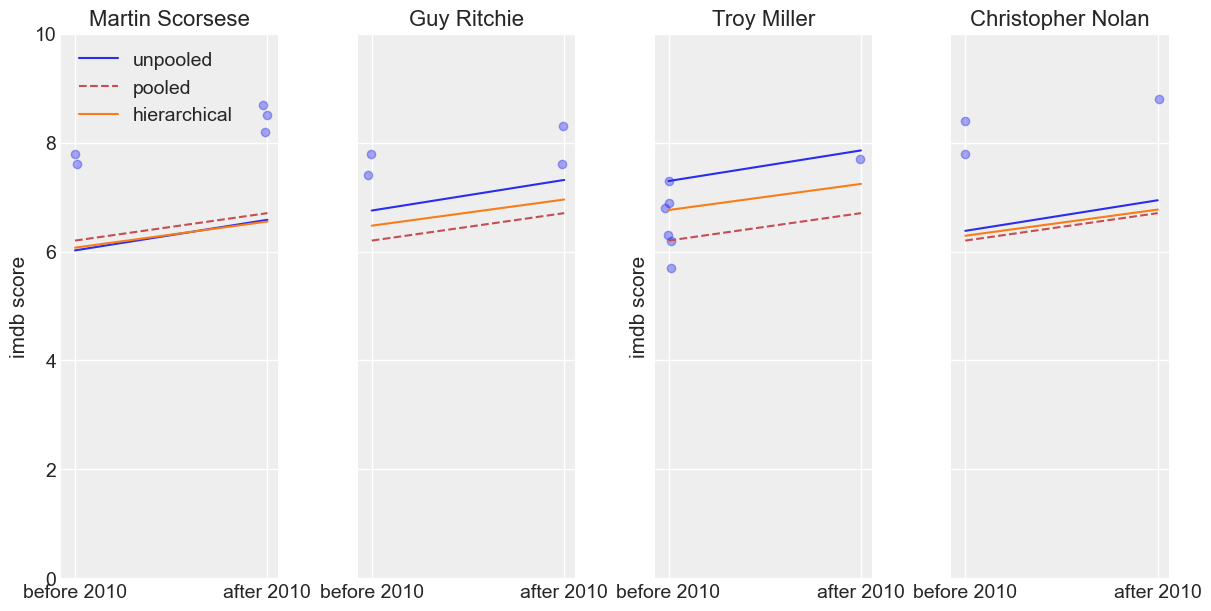

In [45]:
#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()



post_hier = az.extract_dataset(hier_trace.posterior)

#slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each county (samples of each county are averaged)
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=directors_names)


for i,c in enumerate(sample_directors):
    
    # Plot county data
    y = score[df.director==c]
    x = before_2010_c[df.director==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(before_2010_c.min(), before_2010_c.max())
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[directors_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[directors_lookup[c]] + beta_hier * xvals,  label="hierarchical" )
    #axes[i].plot(xvals, mp*xvals+ beta_hier[county_lookup[c]], 'k:')
    
    axes[i].set_xticks([before_2010_c.min(), before_2010_c.max()])
    axes[i].set_xticklabels(['before 2010', 'after 2010'])
    axes[i].set_ylim(0, 10)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('imdb score')
    axes[0].legend()

The data we have at our disposal are not enough to fit properly the models and get good results. THough we can see the hierarchical model is a compromise of the pooled and the unpooled model as we would have expected.
The hierarchical model is very colse to the pooled model for the directors with few samples and it is close to the unpooled one when we have more samples for that directors.

# Ranking models according to WAIC

* WAIC is a model selection criterion for Bayesian models.



In [46]:
# the hierarchical model is ranked first
az.waic (pooled_trace)
comp_df = az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')
comp_df

C:\Users\loddo\AppData\Local\mambaforge\envs\bpp\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\loddo\AppData\Local\mambaforge\envs\bpp\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
unpooled,0,-4707.377114,1322.358125,0.000000,0.564172,33.540084,0.000000,True,log
hierarchical,1,-4826.797301,1055.312926,119.420186,0.404078,44.107930,34.808143,True,log
pooled,2,-5265.759482,3.362238,558.382368,0.031750,48.352920,50.742093,False,log


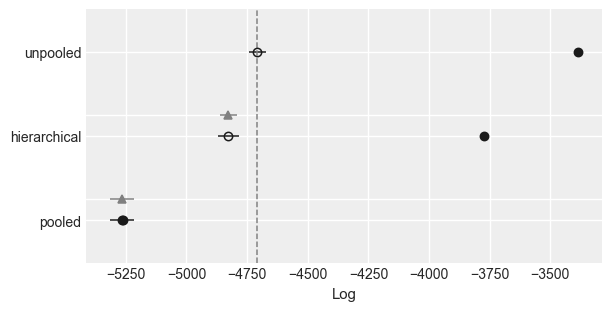

In [47]:
az.plot_compare(comp_df);

The unpooled model actually consists in N completely separate normal-normal sub-models for each director. 

1. The mean imdb film score of each director is between $6.5-3*1=3.5$ and $6.5+3*1=9.5$ with probability 99%
2. The imdb score measurements of each director are in a range of width $0.4*10=4$ with probability 99%

# Posterior distribution of the mean for the director Troy Miller

In [54]:
directors_lookup['Troy Miller']

247

In [55]:
print(hier_trace.posterior.keys())

KeysView(<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, alpha_dim_0: 2641)
Coordinates:
  * chain        (chain) int32 0 1 2 3
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * alpha_dim_0  (alpha_dim_0) int32 0 1 2 3 4 5 ... 2636 2637 2638 2639 2640
Data variables:
    mu_a         (chain, draw) float64 6.261 6.251 6.236 ... 6.246 6.261 6.229
    alpha        (chain, draw, alpha_dim_0) float64 6.228 5.704 ... 6.919 6.588
    beta         (chain, draw) float64 0.4493 0.529 0.4562 ... 0.4172 0.4791
    sigma_a      (chain, draw) float64 0.7308 0.7682 0.7693 ... 0.7278 0.6946
    sigma_y      (chain, draw) float64 0.8045 0.7721 0.8043 ... 0.7967 0.8031
Attributes:
    created_at:                 2023-01-22T09:27:06.339665
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              35.258624792099
    tuning_steps:               1000)


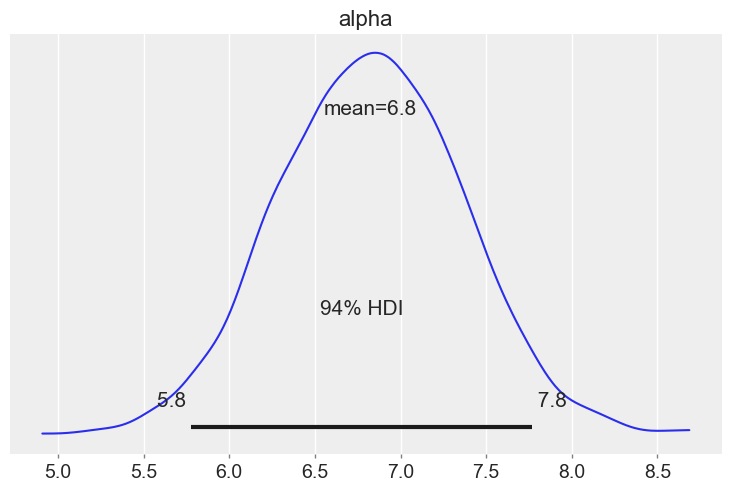

In [56]:
coords = {"alpha_dim_0": 247}
with hier_model:
    az.plot_posterior(hier_trace, var_names=["alpha"], point_estimate='mean', coords=coords)

# Prediction future measure for the director Troy Miller

In [57]:
np.unique(before_2010_c)

array([-0.13166954,  0.86833046])

In [58]:
#predictive distribution for a new measure in LAC QUI PARLE, according to the unpooled and the varying-intercept model
# Part 1

before_2010_0 = 0.13166954


#get the trace samples
post_hier    = az.extract_dataset(hier_trace.posterior)
post_unp    = az.extract_dataset(unpooled_trace.posterior)

#samples of the slope
beta_hier =  post_hier.beta.values
beta_unp =  post_unp.beta.values

#samples of the intercept for LAC 
alpha_lac_hier = post_hier.alpha.values[directors_lookup['Troy Miller']] 
alpha_lac_unp = post_unp.alpha.values[directors_lookup['Troy Miller']] 

#samples of sd
sigma_y_hier =  post_hier.sigma_y.values
sigma_y_unp =  post_unp.sigma_y.values

In [59]:
#Part 2 - computing the predictive based on the samples from the trace
y_new_hier = np.zeros(len(beta_hier))
y_new_unp = np.zeros(len(beta_unp))

#this could be easily vectorized. I leave the for loop mainly for clarity
for i, current_mu in enumerate(beta_hier):
        #to have a more precise quantification, we could generate more than one values   with the i-th sample of parameters.
        # that is how pymc3 implements the predictive checks.
        y_new_hier[i] = np.random.normal (loc = alpha_lac_hier[i] + beta_hier[i] *  before_2010_0 , scale = sigma_y_hier[i])
        y_new_unp[i] = np.random.normal (loc = alpha_lac_unp[i] + beta_unp[i] *  before_2010_0 , scale = sigma_y_unp[i])

#the predictive distribution of the unpooled is much larger median and more uncertaint (larger std)        
a=  pd.DataFrame(y_new_hier).describe()
b = pd.DataFrame(y_new_unp).describe()
c =  pd.concat ([a,b], axis=1)
c.columns = ['hier', 'unpooled']
c

,hier,unpooled
count,4000.000000,4000.000000
mean,6.882066,7.448375
std,0.952293,0.992075
min,3.573040,4.046888
25%,6.255327,6.785918
50%,6.907316,7.439501
75%,7.521001,8.116278
max,10.553328,10.851302


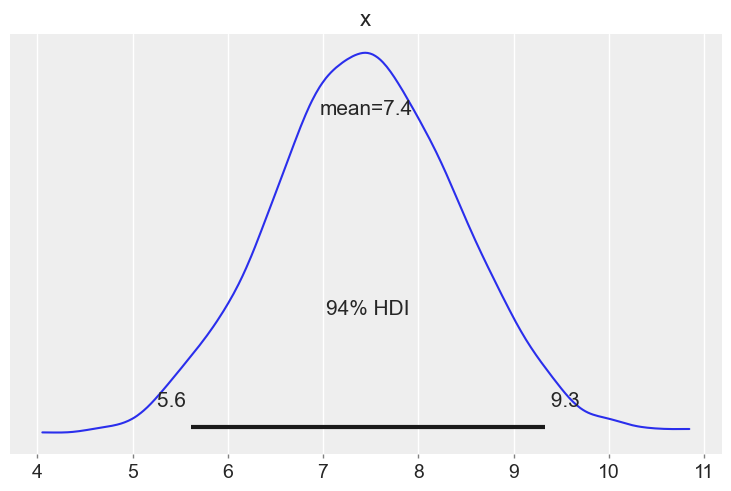

In [73]:
with unpooled_model:
    az.plot_posterior(y_new_unp)

In [60]:
# def sample_posterior_predictive(trace, model, samples=100, random_seed=None):
#     """
#     Generate posterior predictive samples from a PyMC3 model.
#     """
#     with model:
#         # Get the posterior predictive distribution for each variable
#         ppc = {}
#         for var in model.unobserved_RVs:
#             ppc[var.name] = var.distribution.random(size=(samples,))

#         # Assign values to observed variables
#         for obs in model.observed_RVs:
#             obs.value = trace[obs.name][-1]

#         # Compute the log likelihood for each sample
#         logp = [model.logpt for _ in range(samples)]

#     return {'ppc': ppc, 'logp': logp}

# # Generate posterior predictive samples
# posterior_predictive = sample_posterior_predictive(hier_trace, hier_model, samples=100)


# Posterior distribution  of a novel group

In [61]:
# predictive distribution for a measure taken in a new county.
# This is not possible with the unpooled model.
# Part 1 

post_hier = az.extract_dataset(hier_trace.posterior)

# First, we create plausible value of intercepts by sampling from the population of intercepts 
mu_a = post_hier.mu_a.values
sigma_a = post_hier.sigma_a.values
alpha_new = np.zeros(len(mu_a))

#for i, current_mu in enumerate(mu_a):
 #   alpha_new[i] = np.random.normal (loc = mu_a[i], scale = sigma_a[i])

#vectorized implementation is more elegant, but equivalent to the loop above
alpha_new = np.random.normal (loc = mu_a, scale = sigma_a)

 #samples of the slope and of the sigma   
beta_hier =  post_hier.beta.values
sigma_y =  post_hier.sigma_y.values

In [62]:
# predictive distribution for a measure taken in a new county.
# Part 2 
        
#predictive distribution for a new measure in the new county
y_new = np.zeros(len(alpha_new))

for i, current_mu in enumerate(alpha_new):
        y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  before_2010_0 , scale = sigma_y[i])

pd.DataFrame(y_new).describe()

,0
count,4000.000000
mean,6.303931
std,1.078931
min,2.116171
25%,5.566613
50%,6.325556
75%,7.015290
max,10.089203


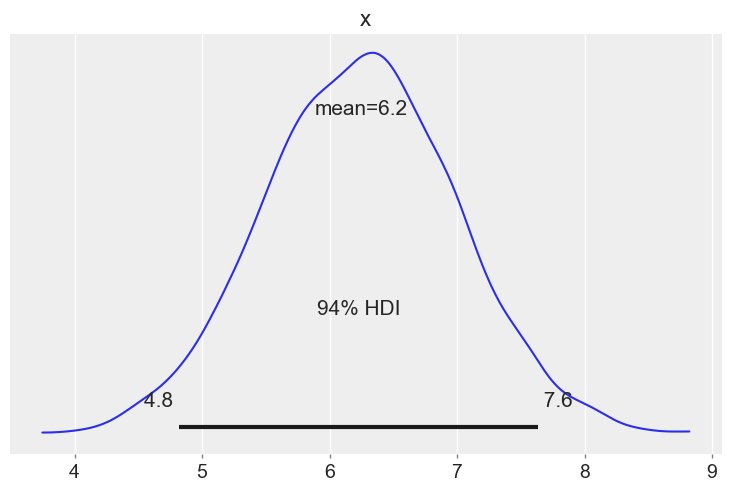

In [74]:
with hier_model:
    az.plot_posterior(alpha_new)

# Convergence diagnostic

In Bayesian statistics, convergence diagnostic is a method used to ensure that a Markov Chain Monte Carlo (MCMC) algorithm has reached a state where the samples it generates are representative of the target distribution.

When using PyMC3, a common way to check the convergence of a model is to use the Gelman-Rubin (GR) statistic, also known as the Potential Scale Reduction Factor (PSRF). The GR statistic compares the variance of the chain means to the mean of the within-chain variances. If the GR statistic is close to 1, it suggests that the chains have converged to the target distribution. A value greater than 1 indicates that the chains have not yet converged.

Another popular diagnostic is the Geweke diagnostic, it compares the mean and variance of the beginning and end of a chain, to check if the sample in the beginning of the chain is coming from the same distribution as the sample in the end of the chain.

Additionally, you can use the pm.traceplot() function to check the trace of the sampling process, and look for patterns such as high autocorrelation or lack of mixing.

It's also a good idea to check the traceplot and the R-hat values to see the convergence of the model.
You can use the az.summary(hier_trace) function to get the summary of the trace and check the R-hat value for each parameter

R-hat, also known as the Gelman-Rubin statistic, is a measure of convergence for Markov Chain Monte Carlo (MCMC) algorithms. It compares the variance of the chain means to the mean of the within-chain variances, and it's used to check if multiple chains have reached a common distribution.

The R-hat statistic is calculated for each variable in the model, and it's defined as:

R-hat = sqrt(Vhat / W)

Where Vhat is the pooled variance of the multiple chains and W is the within-chain variance.

In general, if R-hat is close to 1, it suggests that the chains have converged to the target distribution. A value greater than 1 indicates that the chains have not yet converged, which means that the model needs more samples or that the tuning of the sampler should be improved.

In [64]:
az.summary(unpooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],6.095,0.489,5.157,6.976,0.009,0.006,3291.0,1829.0,1.00
alpha[1],4.319,0.686,3.109,5.651,0.012,0.009,3066.0,2065.0,1.00
alpha[2],6.682,0.494,5.797,7.649,0.009,0.007,2796.0,1805.0,1.00
alpha[3],5.364,0.693,4.100,6.686,0.014,0.010,2436.0,2099.0,1.00
alpha[4],7.659,0.716,6.273,8.940,0.013,0.009,2903.0,1958.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha[2638],7.383,0.676,6.096,8.610,0.012,0.009,2945.0,1907.0,1.00
alpha[2639],6.288,0.691,5.016,7.622,0.014,0.010,2516.0,2042.0,1.00
alpha[2640],5.284,0.504,4.393,6.274,0.009,0.006,3242.0,1962.0,1.00
beta,0.562,0.074,0.427,0.702,0.002,0.001,1761.0,2021.0,1.00


In [71]:
rhat_values = az.rhat(unpooled_trace)
alpha_rhat = rhat_values['alpha']
sum_alpha_rhat = alpha_rhat.sum()
sum_alpha_rhat

<xarray.DataArray 'alpha' ()>
array(2646.2584474)

We have 2640 alpha parameters and the sum of the R-hat coulumns correspond to 2646, we can say that the values are mostly around 1 and the model converges.

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma_y'}>,
        <AxesSubplot:title={'center':'sigma_y'}>]], dtype=object)

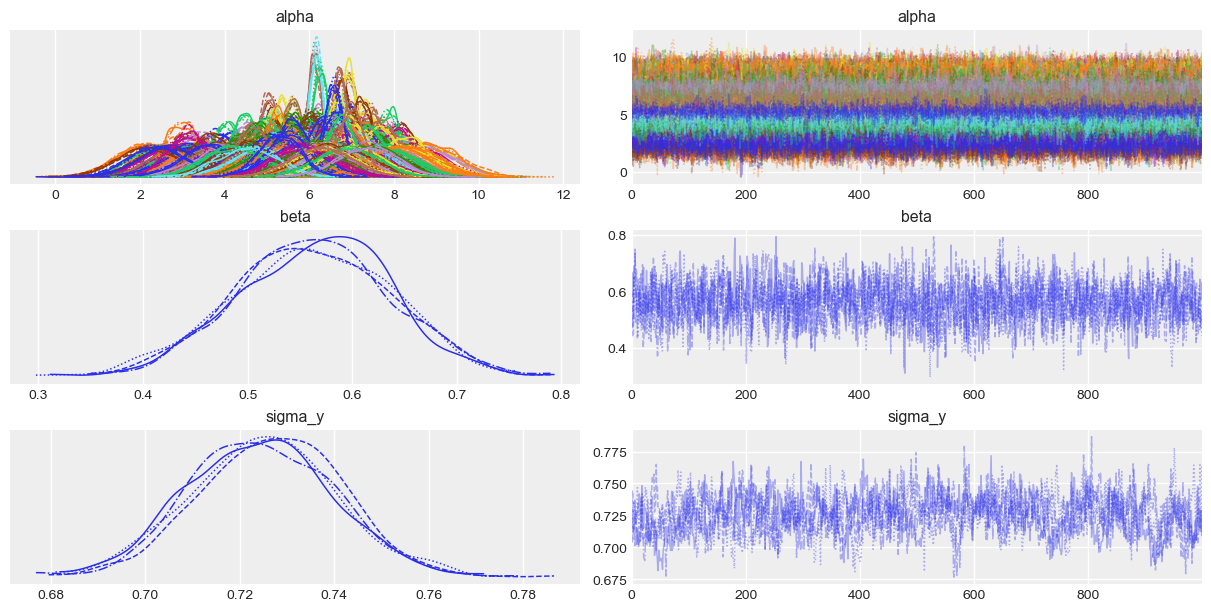

In [67]:
az.plot_trace(unpooled_trace)

We can look in the trace of the sampling process of alpha for patterns such as high autocorrelation or lack of mixing that would indicate that the sampling process has not yet converged. In our case we do not see such things so we can again assume that the model has converged.